In [1]:
import torch

from recom.datasets import load_ml_small_rating

# load data
dataset = load_ml_small_rating(need_raw=True)

# load features
ratings = dataset['raw']
ratings_train_dict = dataset['train_dict']
ratings_test_dict = dataset['test_dict']
n_user = dataset['n_user']
n_item = dataset['n_item']
user2ix = dataset['user2ix']
ix2user = dataset['ix2user']
item2ix = dataset['item2ix']
ix2item = dataset['ix2item']

del dataset

print(f'Users: {n_user}, Items: {n_item}. Sparsity: {round(1-len(ratings)/n_user/n_item, 4)}')
print(f'User reduced from {len(user2ix.keys())} to {len(ratings_train_dict.keys())}')

Users: 610, Items: 9724. Sparsity: 0.983
User reduced from 610 to 607


In [22]:
import sys, os
sys.path.append(os.getcwd())

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from recom.utils.sampler import mf_data_loader

flatten_dict_score = lambda rat_dic: [item for user in rat_dic
                                      for item in rat_dic[user].values()]


def rating_min_max_scalar(rat_dict, report_min_max=False):
    flatten_dict = flatten_dict_score(rat_dict)
    score_min = min(flatten_dict)
    score_max = max(flatten_dict)

    res = {}
    for user in rat_dict:
        res[user] = {}
        for item in rat_dict[user]:
            res[user][item] = (rat_dict[user][item]-score_min)/(score_max-score_min)

    if not report_min_max:
        return res
    else:
        return {'rating':res, 'min':score_min, 'max':score_max}

def RMSE(rate, preds):
    """ RMSE loss
        Mainly for evaluating the MF model

    :param rate: tensor of original rating

    :param preds: tensor of predictions

    :return: rmse value of the predictions
    """

    return ((rate - preds.view(-1))**2).mean()


class _MF(nn.Module):
    """ Base class of Matrix Factorization.
        Latent factor based model for recommendation.
    """
    def __init__(self, n_user, n_item, k_dim):
        super(_MF, self).__init__()

    def pred(self, user, item):
        """ Predict rating for user and a set of item based on their latent factors/ embeddings.
        """
        pass

    def forward(self, user, item, rating):
        """ The way model train itself by inputs
        """
        pass

    def fit(self, train_dict, opt_fn
            , batch_size=128
            , n_epochs=128
            , user_per_ep=128, item_per_ep=32
            , report_interval=10, use_cuda=False):

        import time
        from torch import autograd, LongTensor, device

        if use_cuda:
            compute_device = device('cuda')
            self.cuda()
        else:
            compute_device = device('cpu')

        losses = []

        t0 = time.time()
        for epoch in range(n_epochs):
            train_data = mf_data_loader(train_dict, user_per_ep, item_per_ep, batch_size)

            for i, batch in enumerate(train_data):
                user, item, rate = batch

                self.zero_grad()

                # variablize
                user = autograd.Variable(LongTensor(user)).to(compute_device)
                item = autograd.Variable(LongTensor(item)).to(compute_device)
                rate = autograd.Variable(rate).to(compute_device)

                preds = self(user, item)
                loss = RMSE(rate, preds)

                loss.backward()
                opt_fn.step()
                losses.append(loss.data.to(compute_device).tolist())
            if report_interval > 0 \
                    and ((epoch+1) % report_interval == 0):
                t1=time.time()
                print(f'Epoch: {epoch+1}, Time: {round(t1-t0,2)}, /Average loss {round(sum(losses[-report_interval:])/report_interval, 5)}')
                t0=time.time()

        self.last_train_loss = losses

        return self

    def pred_on_candidate_dict(self, cand_dict):
        from torch import argsort

        predict = {}

        for user in cand_dict:
            candidate = cand_dict[user]
            pred = self.pred(user, candidate).view(-1)
            pred_ix = argsort(-pred)
            predict[user] = [candidate[ix] for ix in pred_ix]

        return predict

class PMF(_MF):
    def __init__(self, n_user, n_item, k_dim
                     , std_user=1, std_item=1):
        super(_MF, self).__init__()
        self.items = list(range(n_item))
        # embeddings of interest
        self.embedding_user = nn.Embedding(n_user, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # init param
        nn.init.normal_(self.embedding_user.weight, mean=0, std=std_user)
        nn.init.normal_(self.embedding_item.weight, mean=0, std=std_item)
        self.sigmoid = F.sigmoid

    def pred(self, user, item):
        from torch import LongTensor

        # Tensorize
        if isinstance(user, int): user = LongTensor([user])
        if isinstance(user, list): user = LongTensor(user)
        if isinstance(item, int): item = LongTensor([item])
        if isinstance(item, list): item = LongTensor(item)

        user_emb = self.embedding_user(user)
        item_emb = self.embedding_item(item)

        return user_emb @ item_emb.T # dot product

    def forward(self, user, item):
        return (self.embedding_user(user) \
                * self.embedding_item(item)).sum(1)

    def fit(self, train_dict, opt_fn
            , batch_size=128
            , n_epochs=128
            , user_per_ep=128, item_per_ep=32
            , report_interval=10, use_cuda=False):

        import time
        from torch import autograd, LongTensor, device

        if use_cuda:
            compute_device = device('cuda')
            self.cuda()
        else:
            compute_device = device('cpu')

        proj_train_dict = rating_min_max_scalar(train_dict)

        losses = []

        t0 = time.time()
        for epoch in range(n_epochs):
            train_data = mf_data_loader(proj_train_dict, user_per_ep, item_per_ep, batch_size)

            for i, batch in enumerate(train_data):
                user, item, rate = batch

                self.zero_grad()

                # variablize
                user = autograd.Variable(LongTensor(user)).to(compute_device)
                item = autograd.Variable(LongTensor(item)).to(compute_device)
                rate = autograd.Variable(rate).to(compute_device)

                # use sigmoid as projection
                preds = self(user, item)
                loss = RMSE(rate, self.sigmoid(preds))

                loss.backward()
                opt_fn.step()
                losses.append(loss.data.to(compute_device).tolist())
            if report_interval > 0 \
                    and ((epoch+1) % report_interval == 0):
                t1=time.time()
                print(f'Epoch: {epoch+1}, Time: {round(t1-t0,2)}, /Average loss {round(sum(losses[-report_interval:])/report_interval, 5)}')
                t0=time.time()

        self.last_train_loss = losses

        return self


class ConstrainedPMF(_MF):
    def __init__(self, n_user, n_item, k_dim
                 , std_user=1, std_item=1):
        super(_MF, self).__init__()
        self.n_user = n_user # placeholder
        # embeddings of interest
        self.user_offset = nn.Embedding(n_user, 1)
        self.latent_similarity = nn.Embedding(n_item, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # init param
        nn.init.normal_(self.user_offset.weight, mean=0, std=0)
        nn.init.normal_(self.latent_similarity.weight, mean=0, std=std_user)
        nn.init.normal_(self.embedding_item.weight, mean=0, std=std_item)
        # rating history
        self.rat_hist = None
        # layer
        self.sigmoid = F.sigmoid

    def pred(self, user, item):
        from torch import LongTensor

        # Tensorize
        if isinstance(user, int): user = [user]
        if isinstance(item, int): item = LongTensor([item])
        if isinstance(item, list): item = LongTensor(item)

        user_offset = self.user_offset(LongTensor(user))

        user_emb = torch.row_stack([
            self.latent_similarity(self.rat_hist[int(u)]).mean(0)
            for u in user
        ])

        item_emb = self.embedding_item(item)

        # dot product
        return (user_emb + user_offset) @ item_emb.T

    def forward(self, user_ix, user_emb, item):
        user_offset = self.user_offset(user_ix)
        embedding_user = user_offset + user_emb

        # print(user_offset.is_cuda)
        # print(embedding_user.is_cuda)
        # print(self.embedding_item(item).is_cuda)

        return (embedding_user \
                * self.embedding_item(item)).sum(1)

    def fit(self, train_dict, opt_fn
            , batch_size=128
            , n_epochs=128
            , user_per_ep=128, item_per_ep=32
            , report_interval=10, use_cuda=False):

        import time
        from torch import autograd, LongTensor, device

        if use_cuda:
            compute_device = device('cuda')
            self.cuda()
            self.latent_similarity.to('cpu')
        else:
            compute_device = device('cpu')

        self.rat_hist = self.get_rating_history(train_dict)
        proj_train_dict = rating_min_max_scalar(train_dict)

        losses = []

        t0 = time.time()
        for epoch in range(n_epochs):
            train_data = mf_data_loader(proj_train_dict, user_per_ep, item_per_ep, batch_size)

            for i, batch in enumerate(train_data):
                user, item, rate = batch

                self.zero_grad()

                # variablize
                user_emb = torch.row_stack([
                    self.latent_similarity(self.rat_hist[int(u)]).mean(0) \
                    for u in user
                ]).to(compute_device)

                user_ix = autograd.Variable(LongTensor(user)).to(compute_device)

                item = autograd.Variable(LongTensor(item)).to(compute_device)
                rate = autograd.Variable(rate).to(compute_device)

                # use sigmoid as projection
                preds = self(user_ix, user_emb, item)
                loss = RMSE(rate, self.sigmoid(preds))

                loss.backward()
                opt_fn.step()
                losses.append(loss.data.to(compute_device).tolist())

            if report_interval > 0 \
                    and ((epoch+1) % report_interval == 0):
                t1=time.time()
                print(f'Epoch: {epoch+1}, Time: {round(t1-t0,2)}, /Average loss {round(sum(losses[-report_interval:])/report_interval, 5)}')
                t0=time.time()

        self.last_train_loss = losses

        return self

    def get_rating_history(self, rating):
        from torch import LongTensor

        return dict(
            (user, LongTensor(list(rating[user].keys())))
            for user in rating
        )

    def set_history(self, rating)->None:
        self.rat_hist = self.get_rating_history(rating)


In [23]:
from torch import optim
import warnings
warnings.filterwarnings("ignore")

use_cuda = True
report_interval = 1
user_per_ep = 2
item_per_ep = 2

cpmf = ConstrainedPMF(
    n_user=n_user
    , n_item=n_item
    , k_dim=12
    , std_user=1
    , std_item=1
)
# define optimizer
opt = optim.SGD(cpmf.parameters(), lr=0.01, weight_decay=0.01, momentum=0.01)
# train model on gpu, with data and optimizer
cpmf.fit(ratings_train_dict, opt, user_per_ep=user_per_ep, item_per_ep=item_per_ep, n_epochs=5, use_cuda=use_cuda, report_interval=report_interval)
cpmf.to('cpu')

res = cpmf.pred(0, list(range(n_item))).view(-1)
res, res.max(), res.min()

Epoch: 1, Time: 0.01, /Average loss 0.16486
Epoch: 2, Time: 0.0, /Average loss 0.05943
Epoch: 3, Time: 0.01, /Average loss 0.17843
Epoch: 4, Time: 0.0, /Average loss 0.12753
Epoch: 5, Time: 0.01, /Average loss 0.16136


(tensor([-0.0767, -0.2936,  0.2294,  ...,  0.0246, -0.2520, -0.3496],
        grad_fn=<ViewBackward0>),
 tensor(0.9350, grad_fn=<MaxBackward1>),
 tensor(-0.8831, grad_fn=<MinBackward1>))

In [28]:
ratings_test_dict[0]

{0: 4.0,
 62: 3.0,
 136: 5.0,
 224: 5.0,
 314: 4.0,
 398: 5.0,
 484: 4.0,
 513: 5.0,
 592: 4.0,
 705: 5.0,
 781: 5.0,
 788: 5.0,
 815: 5.0,
 835: 5.0,
 899: 5.0,
 914: 4.0,
 926: 5.0,
 968: 5.0,
 995: 5.0,
 1109: 3.0,
 1180: 5.0,
 1223: 5.0,
 1325: 4.0,
 1430: 5.0,
 1492: 5.0,
 1521: 4.0,
 1556: 5.0,
 1576: 5.0,
 1616: 5.0,
 1690: 4.0,
 1767: 4.0,
 1813: 3.0,
 1865: 4.0,
 1916: 5.0,
 1990: 4.0,
 2037: 5.0,
 2156: 5.0,
 2217: 5.0,
 2252: 5.0,
 2300: 5.0,
 2523: 5.0,
 2578: 5.0,
 2692: 4.0,
 2784: 5.0,
 2987: 4.0}

In [30]:
from recom.eval.evaluator import generate_testing_candidates

# init testing candidates
cand_test = generate_testing_candidates(ratings_train_dict, ix2item)

cpmf_pred_results = cpmf.pred_on_candidate_dict(cand_test)


In [31]:
cpmf_pred_results[0]

[5988,
 4490,
 8771,
 2036,
 1401,
 1019,
 2982,
 1519,
 2684,
 2926,
 5375,
 7583,
 8221,
 1603,
 2631,
 8231,
 9111,
 9053,
 4225,
 5671,
 812,
 1681,
 5048,
 891,
 2772,
 1678,
 438,
 5629,
 6769,
 8123,
 2375,
 54,
 5791,
 5042,
 3373,
 7466,
 1799,
 1397,
 215,
 2153,
 1881,
 8406,
 8460,
 2759,
 6825,
 2086,
 6502,
 7566,
 2836,
 7284,
 3966,
 5092,
 388,
 1337,
 269,
 3753,
 602,
 5847,
 3417,
 6845,
 1029,
 4427,
 7341,
 5928,
 1704,
 2223,
 3954,
 3865,
 1301,
 6804,
 3884,
 4358,
 6198,
 6878,
 6423,
 1771,
 3191,
 2552,
 7428,
 199,
 3698,
 1941,
 6377,
 2283,
 5132,
 7452,
 3788,
 6645,
 93,
 2777,
 3062,
 5561,
 3172,
 3672,
 7427,
 2512,
 1112,
 9294,
 4567,
 5588,
 2924,
 3369,
 315,
 2261,
 2775,
 4788,
 7087,
 2296,
 4452,
 725,
 7389,
 4282,
 8272,
 6424,
 1994,
 2260,
 8195,
 9553,
 1530,
 5120,
 5783,
 3674,
 9113,
 2639,
 5697,
 6351,
 8489,
 5647,
 7253,
 4689,
 7794,
 7900,
 7482,
 3806,
 31,
 5331,
 8048,
 7836,
 3941,
 3513,
 3898,
 4097,
 287,
 443,
 1659,
 87

In [32]:
from recom.model.MF import FunkSvd, BiasedFunkSvd
from torch import optim
import warnings
warnings.filterwarnings("ignore")

k_dim = 64
n_epochs = 256
use_cuda = True
report_interval = 32
user_per_ep = 256
item_per_ep = 128

""" 1. FunkSVD """
# init model
fsvd = FunkSvd(
    n_user=n_user
    , n_item=n_item
    , k_dim=k_dim
)
# define optimizer
opt = optim.SGD(fsvd.parameters(), lr=0.01, weight_decay=0.01, momentum=0.01)
# train model on gpu, with data and optimizer
fsvd.fit(ratings_train_dict, opt, user_per_ep=user_per_ep, item_per_ep=item_per_ep, n_epochs=n_epochs, use_cuda=use_cuda, report_interval=report_interval)
# return model to cpu
fsvd = fsvd.to('cpu')


""" 2. Biased SVD """
# from recom.utils.util import compute_rat_bias
#
# # compute bias in training dict
# global_bias, dev_user, dev_item = compute_rat_bias(ratings_train_dict, n_user, n_item)
#
# # init model
# bsvd = BiasedFunkSvd(
#     n_user=n_user
#     , n_item=n_item
#     , k_dim=k_dim
#     , user_deviation=dev_user
#     , item_deviation=dev_item
#     , global_bias=global_bias
# )
# # define optimizer
# opt = optim.SGD(bsvd.parameters(), lr=0.01, weight_decay=0.01, momentum=0.01)
# # train model on gpu, with data and optimizer
# bsvd.fit(ratings_train_dict, opt, user_per_ep=user_per_ep, item_per_ep=item_per_ep, n_epochs=n_epochs, use_cuda=use_cuda, report_interval=report_interval)
# # return model to cpu
# bsvd = bsvd.to('cpu')


""" 3. PMF """
# init model
pmf = PMF(
    n_user=n_user
    , n_item=n_item
    , k_dim=k_dim
    , std_user=1
    , std_item=1
)
# define optimizer
opt = optim.SGD(pmf.parameters(), lr=0.01, weight_decay=0.01, momentum=0.01)
# train model on gpu, with data and optimizer
pmf.fit(ratings_train_dict, opt, user_per_ep=user_per_ep, item_per_ep=item_per_ep, n_epochs=n_epochs, use_cuda=use_cuda, report_interval=report_interval)
# return model to cpu
pmf = pmf.to('cpu')


""" 4. Constrained PMF """
# init model
cpmf = ConstrainedPMF(
    n_user=n_user
    , n_item=n_item
    , k_dim=k_dim
    , std_user=1
    , std_item=1
)
# define optimizer
opt = optim.SGD(cpmf.parameters(), lr=0.01, weight_decay=0.01, momentum=0.01)
# train model on gpu, with data and optimizer
cpmf.fit(ratings_train_dict, opt, user_per_ep=user_per_ep, item_per_ep=item_per_ep, n_epochs=n_epochs, use_cuda=use_cuda, report_interval=report_interval)
cpmf = cpmf.to('cpu')


from recom.eval.evaluator import generate_testing_candidates

# init testing candidates
cand_test = generate_testing_candidates(ratings_train_dict, ix2item)

# predict result
fsvd_pred_results = fsvd.pred_on_candidate_dict(cand_test)
pmf_pred_results = pmf.pred_on_candidate_dict(cand_test)
cpmf_pred_results = cpmf.pred_on_candidate_dict(cand_test)

Epoch: 32, Time: 82.35, /Average loss 14.22968
Epoch: 64, Time: 19.22, /Average loss 14.58032
Epoch: 96, Time: 19.3, /Average loss 14.41608
Epoch: 128, Time: 59.81, /Average loss 14.42969
Epoch: 160, Time: 58.92, /Average loss 14.72559
Epoch: 192, Time: 19.06, /Average loss 14.5495
Epoch: 224, Time: 19.1, /Average loss 14.71893
Epoch: 256, Time: 75.31, /Average loss 14.78943
Epoch: 32, Time: 44.83, /Average loss 0.16756
Epoch: 64, Time: 19.63, /Average loss 0.10034
Epoch: 96, Time: 19.76, /Average loss 0.09785
Epoch: 128, Time: 104.61, /Average loss 0.09317
Epoch: 160, Time: 19.67, /Average loss 0.10053
Epoch: 192, Time: 19.73, /Average loss 0.09686
Epoch: 224, Time: 20.4, /Average loss 0.09666
Epoch: 256, Time: 104.41, /Average loss 0.09775


KeyboardInterrupt: 

In [34]:
cpmf.last_train_loss

AttributeError: 'ConstrainedPMF' object has no attribute 'last_train_loss'

In [116]:
print(res.argsort().numpy()[::-1][:20])

[6739 8901 8574 9592 8654 8478 5282 7899  977 9057 5938 5878 4379 6703
 9658 1783  923  678 3757 2739]


In [95]:
ratings_test_dict[0]

{0: 4.0,
 62: 3.0,
 136: 5.0,
 224: 5.0,
 314: 4.0,
 398: 5.0,
 484: 4.0,
 513: 5.0,
 592: 4.0,
 705: 5.0,
 781: 5.0,
 788: 5.0,
 815: 5.0,
 835: 5.0,
 899: 5.0,
 914: 4.0,
 926: 5.0,
 968: 5.0,
 995: 5.0,
 1109: 3.0,
 1180: 5.0,
 1223: 5.0,
 1325: 4.0,
 1430: 5.0,
 1492: 5.0,
 1521: 4.0,
 1556: 5.0,
 1576: 5.0,
 1616: 5.0,
 1690: 4.0,
 1767: 4.0,
 1813: 3.0,
 1865: 4.0,
 1916: 5.0,
 1990: 4.0,
 2037: 5.0,
 2156: 5.0,
 2217: 5.0,
 2252: 5.0,
 2300: 5.0,
 2523: 5.0,
 2578: 5.0,
 2692: 4.0,
 2784: 5.0,
 2987: 4.0}

In [93]:
ratings_train_dict[0]

{2: 4.0,
 5: 4.0,
 43: 5.0,
 46: 5.0,
 89: 5.0,
 97: 4.0,
 124: 5.0,
 130: 5.0,
 184: 5.0,
 190: 3.0,
 197: 5.0,
 201: 4.0,
 257: 3.0,
 275: 3.0,
 291: 5.0,
 307: 4.0,
 320: 5.0,
 325: 4.0,
 367: 3.0,
 384: 4.0,
 418: 4.0,
 436: 3.0,
 461: 5.0,
 476: 4.0,
 485: 5.0,
 508: 4.0,
 509: 4.0,
 510: 4.0,
 520: 5.0,
 546: 3.0,
 551: 5.0,
 559: 3.0,
 594: 3.0,
 615: 3.0,
 632: 4.0,
 701: 5.0,
 720: 5.0,
 723: 4.0,
 734: 5.0,
 767: 3.0,
 782: 5.0,
 783: 5.0,
 786: 5.0,
 787: 3.0,
 789: 5.0,
 797: 4.0,
 801: 5.0,
 810: 4.0,
 819: 5.0,
 827: 5.0,
 828: 4.0,
 830: 5.0,
 855: 4.0,
 862: 5.0,
 897: 5.0,
 898: 5.0,
 906: 5.0,
 908: 4.0,
 910: 5.0,
 913: 5.0,
 919: 2.0,
 920: 5.0,
 922: 5.0,
 924: 5.0,
 938: 5.0,
 954: 5.0,
 956: 3.0,
 963: 4.0,
 973: 5.0,
 976: 5.0,
 980: 5.0,
 989: 5.0,
 1035: 4.0,
 1059: 3.0,
 1075: 3.0,
 1083: 3.0,
 1125: 4.0,
 1145: 4.0,
 1153: 5.0,
 1170: 4.0,
 1182: 3.0,
 1189: 5.0,
 1217: 5.0,
 1219: 4.0,
 1234: 3.0,
 1260: 3.0,
 1297: 5.0,
 1318: 4.0,
 1331: 5.0,
 1332: 4.0,


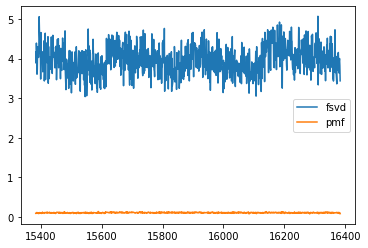

In [117]:
loss_fsvd = fsvd.last_train_loss
loss_pmf = pmf.last_train_loss

import matplotlib.pyplot as plt

plt.plot(list(range(len(loss_fsvd)))[-1000:], loss_fsvd[-1000:])
plt.plot(list(range(len(loss_pmf)))[-1000:], loss_pmf[-1000:])

plt.legend(['fsvd', 'pmf'])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 0.0, 0.0, 0.0032948929159802307, 0.004942339373970346, 0.004942339373970346, 0.004942339373970346, 0.004942339373970346, 0.004942339373970346, 0.004942339373970346)
(0.0, 0.0, 0.004942339373970346, 0.008237232289950576, 0.009884678747940691, 0.013179571663920923, 0.018121911037891267, 0.02471169686985173, 0.032948929159802305, 0.032948929159802305) 

(0.0, 0.0, 0.0, 0.0016474464579901153, 0.002356963028127501, 0.002356963028127501, 0.002356963028127501, 0.002356963028127501, 0.002356963028127501, 0.002356963028127501)
(0.0, 0.0, 0.003118268963285622, 0.004765715421275736, 0.005475231991413121, 0.006749870565497279, 0.008510367371632478, 0.010706962648952633, 0.013305520118357318, 0.013305520118357318) 

(0.0, 0.0, 0.0, 9.504032546462476e-05, 0.00011268675698313058, 0.00011090773203780369, 0.00010919536512425674, 0.0001075457100143037, 0.00010595513293916976, 0.0001044202820531564)
(0.0, 0.0, 0.000681351312872455, 0.000681057504073824, 0.0008150553386480621, 0.0008357755609652695,

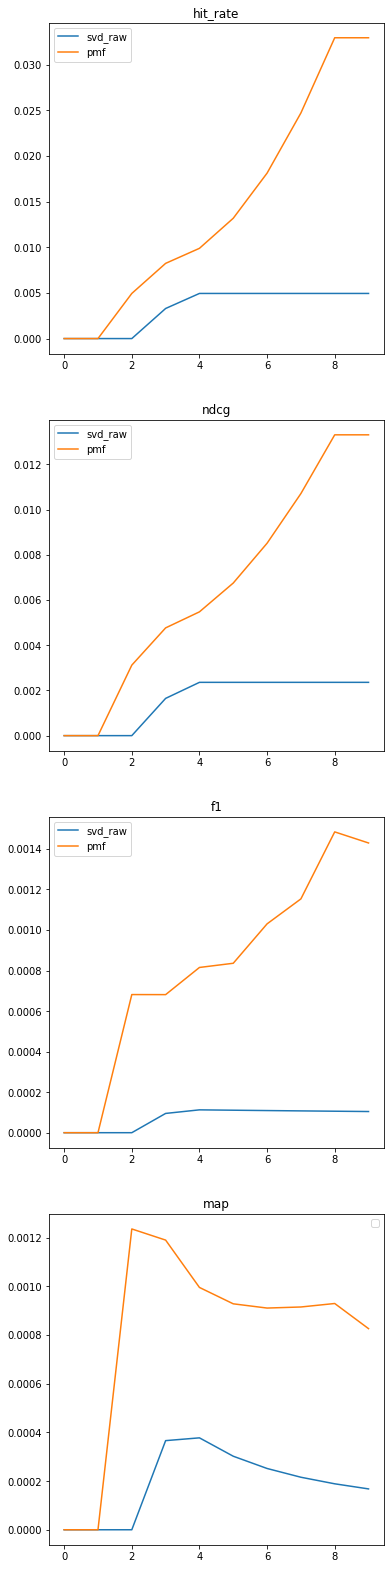

In [119]:
from recom.eval.metrics import hit_rate, ndcg, map, f1
import matplotlib.pyplot as plt

k = 10

metrics = {
    'hit_rate': hit_rate
    , 'ndcg': ndcg
    , 'f1': f1
    , 'map': map
}

preds = {
    'svd_raw': fsvd_pred_results
    , 'pmf': pmf_pred_results
}

fig, ax = plt.subplots(4, figsize=(6, 28))
for i, m_i in enumerate(metrics.keys()):
    val = [[metrics[m_i](ki, ratings_test_dict, pred) \
            for pred in preds.values()] \
           for ki in range(k)]
    val1, val2 = zip(*val)
    print(val1)
    print(val2, '\n')
    ax[i].plot(list(range(k)), val)
    ax[i].legend(list(preds.keys()))
    ax[i].set_title(m_i)

plt.legend()
plt.show()

In [1]:
import sys, os
sys.path.append(os.getcwd())

import torch.nn as nn
from torch import Tensor
from recom.utils.sampler import mf_data_loader

def RMSE(preds):
    """ RMSE loss of prediction

    :param preds: tensor of predictions

    :return: rmse value of the predictions
    """
    return (preds**2).mean()


class _MF(nn.Module):
    """ Base class of Matrix Factorization.
        Latent factor based model for recommendation.
    """
    def __init__(self, n_user, n_item, k_dim):
        super(_MF, self).__init__()

    def pred(self, user, item):
        """ Predict rating for user and a set of item based on their latent factors/ embeddings.
        """
        pass

    def forward(self, user, item, rating):
        """ The way model train itself by inputs
        """
        pass

    def fit(self):
        """ How the model train itself via inputs
        """
        pass

    def pred_on_candidate_dict(self, cand_dict):
        """ The result of predictions on ratings
        """
        pass


class FunkSvd(_MF):
    def __init__(self, n_user, n_item, k_dim, mu_emb=0, sig_emb=0):
        super(_MF, self).__init__()
        self.items = list(range(n_item))
        # embeddings of interest
        self.embedding_user = nn.Embedding(n_user, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # init param
        nn.init.normal(self.embedding_user.weight, mean=mu_emb, std=sig_emb)
        nn.init.normal(self.embedding_item.weight, mean=mu_emb, std=sig_emb)

    def pred(self, user, item):
        """ Predict rating for user and a set of item based on their latent factors/ embeddings.

        :param user: int, list, or tensor
            The index of user(s) of interest.

        :param item: int, list, or tensor
            The index of item(s) of interest

        :return: prediction of score
        """
        from torch import LongTensor

        # Tensorize
        if isinstance(user, int): user = LongTensor([user])
        if isinstance(user, list): user = LongTensor(user)
        if isinstance(item, int): item = LongTensor([item])
        if isinstance(item, list): item = LongTensor(item)

        user_emb = self.embedding_user(user)
        item_emb = self.embedding_item(item)

        return user_emb @ item_emb.T # dot product

    def forward(self, user, item, rating):
        preds = self.pred(user, item)
        return rating - preds

    def fit(self, train_dict, opt_fn
            , batch_size=128
            , n_epochs=128
            , user_per_ep=128, item_per_ep=32
            , report_interval=10, use_cuda=False):

        import time
        from torch import autograd, LongTensor, device

        if use_cuda:
            compute_device = device('cuda')
            self.cuda()
        else:
            compute_device = device('cpu')

        losses = []

        t0 = time.time()
        for epoch in range(n_epochs):
            train_data = mf_data_loader(train_dict, user_per_ep, item_per_ep, batch_size)

            for i, batch in enumerate(train_data):
                user, item, rate = batch

                self.zero_grad()

                # variablize
                user = autograd.Variable(LongTensor(user)).to(compute_device)
                item = autograd.Variable(LongTensor(item)).to(compute_device)
                rate = autograd.Variable(rate).to(compute_device)

                preds = self(user, item)
                loss = RMSE(rate, preds)

                loss.backward()
                opt_fn.step()
                losses.append(loss.data.to(compute_device).tolist())
            if report_interval > 0 \
                    and ((epoch+1) % report_interval == 0):
                t1=time.time()
                print(f'Epoch: {epoch+1}, Time: {round(t1-t0,2)}, /Average loss {round(sum(losses[-report_interval:])/report_interval, 5)}')
                t0=time.time()

        self.last_train_loss = losses

        return self

    def pred_on_candidate_dict(self, cand_dict):
        from torch import argsort

        predict = {}

        for user in cand_dict:
            candidate = cand_dict[user]
            pred = self.pred(user, candidate).view(-1)
            pred_ix = argsort(-pred)
            predict[user] = [candidate[ix] for ix in pred_ix]

        return predict


class PMF(_MF):
